In [1]:
local_file = "reviews_Apps_for_Android_5.json.gz"
!curl -o  $local_file https://storage.googleapis.com/tad2018/reviews_Apps_for_Android_5.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91.0M  100 91.0M    0     0   154M      0 --:--:-- --:--:-- --:--:--  154M


In [2]:
#code taken by lab4 of TEXT AS DATA course and notebook BERT Fine-Tuning Tutorial with PyTorch By Chris McCormick and Nick Ryan
import gzip
import json
import pandas as pd
!pip install transformers

review_list = list()
# Construct a dataframe, by opening the JSON file line-by-line
with gzip.open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    review = json.loads(line)
    # asin is the product number, overall is the number of stars awarded by the user for that product
    review_list.append( (review['asin'], review['reviewerID'], review['reviewText'], review['summary'], review['overall']))
                   
print("We have %d reviews in our dataset"  % len(review_list))

collabels = ['productId', 'reviewerID', 'reviewText', 'summary', 'overall']
reviews = pd.DataFrame(review_list, columns=collabels)
reviews.head()

We have 752937 reviews in our dataset


productId  ... overall
0  B004A9SDD8  ...     3.0
1  B004A9SDD8  ...     5.0
2  B004A9SDD8  ...     5.0
3  B004A9SDD8  ...     5.0
4  B004A9SDD8  ...     5.0

[5 rows x 5 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56be549cc0>]],
      dtype=object)

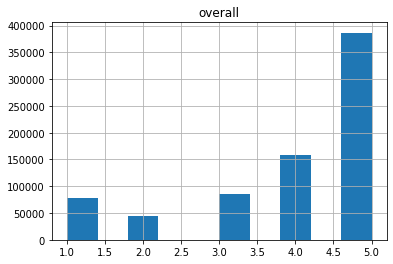

In [3]:
reviews.hist('overall')

In [0]:
def create_label(x):
    if x > 3:
        return 1 # 'positive' 
    return 0 # 'negative'
#create the label for each review  
reviews['Class'] = reviews.overall.apply(create_label)

In [0]:
# shuffle the data randomly to avoid possible bias.
random_reviews = reviews.sample(frac=1)

# The min limits the size of the dataset loaded to 30k, 1/8 of the total data. 
# It's set to not be "too big" for this lab. 
review_limit = min(15000, len(random_reviews))
random_reviews = random_reviews.iloc[:review_limit, :]

# 1. Split the data 80/20 train/test
train_split = int(len(random_reviews) * 0.8)
tmp_train = random_reviews.iloc[:train_split,:]
tmp_test = random_reviews.iloc[train_split:,:]


In [6]:
print('Training set contains {:d} reviews.'.format(len(tmp_train)))
print('Test set contains {:d} reviews.'.format(len(tmp_test)))

number_positive_train = sum(tmp_train['Class'] == 1)
number_positive_test = sum(tmp_test['Class'] == 1)

print('Training set contains %0.0f%% positive reviews' % (100*number_positive_train/len(tmp_train)))
print('Test set contains %0.0f%% positive reviews' % (100*number_positive_test/len(tmp_test)))

Training set contains 12000 reviews.
Test set contains 3000 reviews.
Training set contains 73% positive reviews
Test set contains 71% positive reviews


In [0]:
#to use GPU while training
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
train_labels_initial=tmp_train['Class'].values
train_data=tmp_train['reviewText'].values
test_labels=tmp_test['Class'].values
test_data=tmp_test['reviewText'].values

#BERT

In [9]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
#simple test to see that BertTokenizer works.
# Print the original review.
print(' Original: ', train_data[0])
# Print the review split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_data[0]))
# Print the review mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))

 Original:  I play this game everyday and I never get bored. Im getting a lot better everyday. I definite game you should have in your collection
Tokenized:  ['i', 'play', 'this', 'game', 'everyday', 'and', 'i', 'never', 'get', 'bored', '.', 'im', 'getting', 'a', 'lot', 'better', 'everyday', '.', 'i', 'definite', 'game', 'you', 'should', 'have', 'in', 'your', 'collection']
Token IDs:  [1045, 2377, 2023, 2208, 10126, 1998, 1045, 2196, 2131, 11471, 1012, 10047, 2893, 1037, 2843, 2488, 10126, 1012, 1045, 15298, 2208, 2017, 2323, 2031, 1999, 2115, 3074]


In [11]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every review
for sent in train_data:
    # `encode` will:
    #   (1) Tokenize the review.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # review to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length=512
                   )
    
    # Add the encoded review to the list.
    input_ids.append(encoded_sent)

# Print review 0, now as a list of IDs.
print('Original: ', train_data[0])
print('Token IDs:', input_ids[0])

Original:  I play this game everyday and I never get bored. Im getting a lot better everyday. I definite game you should have in your collection
Token IDs: [101, 1045, 2377, 2023, 2208, 10126, 1998, 1045, 2196, 2131, 11471, 1012, 10047, 2893, 1037, 2843, 2488, 10126, 1012, 1045, 15298, 2208, 2017, 2323, 2031, 1999, 2115, 3074, 102]


In [12]:
print('Max review length: ', max([len(sen) for sen in input_ids]))

Max review length:  512


In [13]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum review length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 512

print('\nPadding/truncating all review to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all review to 512 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


In [0]:
# Create attention masks
attention_masks = []
# For each review...
for sent in input_ids:    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this review.
    attention_masks.append(att_mask)

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#We only split the train to form the validation set
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_labels_initial, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, train_labels_initial,
                                             random_state=2018, test_size=0.2)

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda();

In [0]:
# Note: AdamW is a class from the huggingface library 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [24]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
  
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    600.    Elapsed: 0:01:04.
  Batch    80  of    600.    Elapsed: 0:02:06.
  Batch   120  of    600.    Elapsed: 0:03:09.
  Batch   160  of    600.    Elapsed: 0:04:12.
  Batch   200  of    600.    Elapsed: 0:05:15.
  Batch   240  of    600.    Elapsed: 0:06:18.
  Batch   280  of    600.    Elapsed: 0:07:21.
  Batch   320  of    600.    Elapsed: 0:08:24.
  Batch   360  of    600.    Elapsed: 0:09:27.
  Batch   400  of    600.    Elapsed: 0:10:30.
  Batch   440  of    600.    Elapsed: 0:11:33.
  Batch   480  of    600.    Elapsed: 0:12:36.
  Batch   520  of    600.    Elapsed: 0:13:39.
  Batch   560  of    600.    Elapsed: 0:14:42.

  Average training loss: 0.27
  Training epcoh took: 0:15:45

Running Validation...
  Accuracy: 0.88
  Validation took: 0:01:26

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    600.    Elapsed: 0:01:03.
  Batch    80  of    600.    Elapsed: 0:02:06.
  Batch   120  of    600.    Elap

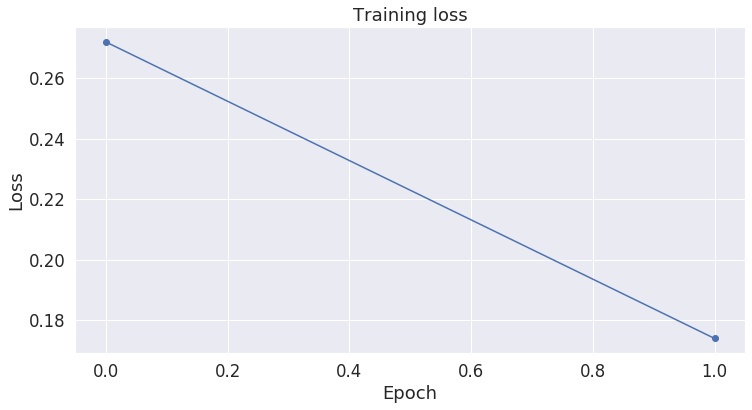

In [25]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [26]:
#Create the test set, as we did before for the train set
input_ids = []

for sent in test_data:
  encoded_sent = tokenizer.encode(
                        sent,                     
                        add_special_tokens = True # Add '[CLS]' and '[SEP]'
                   )    
  input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1353 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [27]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,000 test sentences...
    DONE.


In [32]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

Calculating Matthews Corr. Coef. for each batch...


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
#This function was taken by TaD labs
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels)
  recall = recall_score(predictions, true_labels)
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1) #1 means f_1 measure
  auc = roc_auc_score(predictions, true_labels) 
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f AUC=%0.3f" % (description,accuracy,precision,recall,f1,auc))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted

In [33]:
evaluation_summary("bert as a classifer",flat_true_labels, flat_predictions)

Evaluation for: bert as a classifer
Classifier 'bert as a classifer' has Acc=0.904 P=0.927 R=0.937 F1=0.932 AUC=0.879
              precision    recall  f1-score   support

           0      0.844     0.822     0.832       874
           1      0.927     0.937     0.932      2126

    accuracy                          0.904      3000
   macro avg      0.886     0.879     0.882      3000
weighted avg      0.903     0.904     0.903      3000


Confusion matrix:
 [[ 718  133]
 [ 156 1993]]


#Logistic Regression

In [34]:
#functions taken from TaD labs to help tokenization of the reviews.
import spacy

# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
!python -m spacy download en_core_web_sm#had to change it from en_core_web_md as it did not find it.

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list
import nltk
nltk.download('stopwords')
#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))


✘ No compatible model found for 'en_core_web_sm#had' (spaCy
v2.1.9).

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# 1. Split the data 80/20 train/test
train_split = int(len(random_reviews) * 0.8)
tmp_train_init = random_reviews.iloc[:train_split,:]
tmp_test = random_reviews.iloc[train_split:,:]

# 2. Split the train data into a train/validation split that's 80% train, 20% developemnt 
validation_split = int(train_split * 0.8)
tmp_train = tmp_train_init.iloc[:validation_split,:]
tmp_validation = tmp_train_init.iloc[validation_split:,:]

#for safety we recreate the test and train data here
train_labels=tmp_train['Class'].values
train_data=tmp_train['reviewText'].values

test_labels=tmp_test['Class'].values
test_data=tmp_test['reviewText'].values

validation_labels=tmp_validation['Class'].values
validation_data=tmp_validation['reviewText'].values


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [0]:
#We will try gridsearch to find the best parameters for the vectorization of the tokens,
#either one hot encoding either bag of words.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#instead of CountVectorizer for tokenization, we could have used Bert.
#But in order to work in a Pipeline, we should have wrapped it in a class with .fit() etc.
prediction_pipeline = Pipeline([
              ('selector', ItemSelector(key='reviewText')),
              ('one-hot', CountVectorizer(tokenizer=tokenize_normalize)),
              ('logreg', LogisticRegression(solver='saga'))
              ])

params = {
   'one-hot__binary': (True, False), 
}
grid_search = GridSearchCV(prediction_pipeline, param_grid=params, n_jobs=1, verbose=0, scoring='f1_macro', cv=2)

In [38]:
grid_search.fit(tmp_train, train_labels)
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Best score: 0.765
Best parameters set:
	one-hot__binary: True


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [39]:
predictions=grid_search.predict(tmp_test)
evaluation_summary("Best LR model with one hot encoding",predictions,test_labels)

Evaluation for: Best LR model with one hot encoding
Classifier 'Best LR model with one hot encoding' has Acc=0.837 P=0.903 R=0.872 F1=0.887 AUC=0.807
              precision    recall  f1-score   support

           0      0.676     0.742     0.707       797
           1      0.903     0.872     0.887      2203

    accuracy                          0.837      3000
   macro avg      0.790     0.807     0.797      3000
weighted avg      0.843     0.837     0.839      3000


Confusion matrix:
 [[ 591  283]
 [ 206 1920]]


We can observe that Logistic Regression is performing quite well to the classification task. It reaches almost 89% F1 score. On the other hand, Bert can go to 93% which is very impressive. None the less, Logistic regression's training time was really small. Bert was pretrained and moreover also needs fine tuning to manage to classify correclty. Although Bert can achieve better results than LR, the better results come with the price of larger training time, more complex model etc. 